In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv 
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

# Import the SentimentIntensityAnalyzer class from the nltk.sentiment module. 
# This class is used for sentiment analysis of text data.
from nltk.sentiment import SentimentIntensityAnalyzer

file_path = os.getenv('FILE_PATH')  

df = pd.read_csv(file_path)
df.head()

,__typename,advice,cons,countHelpful,employer,employerResponses,featured,hasEmployerResponse,isCurrentJob,jobTitle,...,ratingCompensationAndBenefits,ratingCultureAndValues,ratingDiversityAndInclusion,ratingOverall,ratingRecommendToFriend,ratingSeniorLeadership,ratingWorkLifeBalance,reviewDateTime,reviewId,summary
0,EmployerReviewRG,"Unfortunately, no matter how good the advice i...","Without realizing it, this office hires a lot ...",7,"{'id': 545277, 'shortName': 'Susi Air', 'squar...",[],False,False,False,{'text': 'Management Trainee'},...,1.0,1,1,1,NEGATIVE,1.0,1.0,2024-12-01T23:43:31.583,93312284,Maid Covered As Management Trainee
1,EmployerReviewRG,"Stop micromanaging everything, train people pr...","Management control is on another level, microm...",3,"{'id': 545277, 'shortName': 'Susi Air', 'squar...",[],False,False,False,{'text': 'Pilot'},...,1.0,1,4,2,NEGATIVE,1.0,1.0,2024-12-24T20:55:31.283,93885460,Wrkg with untr. newbs low sal. bad vibe at wrk...
2,EmployerReviewRG,Just step down already and work on your attitu...,The management's approach often leaves employe...,1,"{'id': 545277, 'shortName': 'Susi Air', 'squar...",[],False,False,False,{'text': 'Management Trainee'},...,0.0,0,0,1,NEGATIVE,0.0,0.0,2025-01-03T00:54:18.913,94035586,LEAVE!!! Don’t Let Your Mental Health Be Throw...
3,EmployerReviewRG,"Advice for management is ""PLEASE FIX YOUR ATTI...",1. Never get appreciation. even we did a great...,6,"{'id': 545277, 'shortName': 'Susi Air', 'squar...",[],False,False,True,{'text': 'Administrator'},...,1.0,1,1,2,NEGATIVE,1.0,1.0,2024-12-06T19:47:12.643,93471008,Not Good for the mental health
4,EmployerReviewRG,Listen to your employees,The French manager’s poor treatment of employe...,2,"{'id': 545277, 'shortName': 'Susi Air', 'squar...",[],False,False,False,"{'text': 'Pilot, First Officer'}",...,3.0,3,4,3,POSITIVE,3.0,4.0,2024-12-04T14:45:23.583,93405277,Ok to build up hours


In [2]:
# Select the 'summary' column
reviews = df['summary']

# Drop rows with missing 'summary'
reviews = reviews.dropna()

# Remove rows with less than 5 words
reviews = reviews[reviews.apply(lambda x: len(x.split()) >= 3)]

# Convert Series to DataFrame
reviews = reviews.to_frame() 
reviews['num_words'] = reviews['summary'].apply(lambda x: len(x.split()))

# Sample 10% of the data
reviews_sampled = reviews.sample(frac=0.1, replace=False, random_state=42)

# Print the sampled DataFrame
print(reviews_sampled.head())

                                              summary  num_words
37                            growing family business          3
23  Most unprofessional corrupt institution in avi...          7
17  If you are a pilot run as far as you can from ...         25


In [3]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

def calculate_sentiment(reviews):
    # Drop rows with missing 'summary'
    reviews = reviews.dropna(subset=['summary'])
    reviews['summary'] = reviews['summary'].astype(str)

    # Initialize SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    # Calculate sentiment score for each review
    reviews['sentiment_score'] = reviews['summary'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Assign sentiment label based on sentiment score
    reviews['sentiment_label'] = reviews['sentiment_score'].apply(
        lambda x: 'Positive' if x >= 0.2 else 'Negative' if x <= -0.2 else 'Neutral'
    )

    # Count the number of positive, negative, and neutral reviews
    sentiment_counts = reviews['sentiment_label'].value_counts()

    # Add the sentiment count as a new column
    reviews['sentiment_count'] = reviews['sentiment_label'].map(sentiment_counts)

    # Print the sentiment counts
    for sentiment, count in sentiment_counts.items():
        print(f"{sentiment}: {count} reviews")

    return reviews

reviews = calculate_sentiment(reviews)
reviews.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Negative: 13 reviews
Positive: 10 reviews
Neutral: 6 reviews


,summary,num_words,sentiment_score,sentiment_label,sentiment_count
0,Maid Covered As Management Trainee,5,0.0000,Neutral,6
1,Wrkg with untr. newbs low sal. bad vibe at wrk...,23,-0.8271,Negative,13
2,LEAVE!!! Don’t Let Your Mental Health Be Throw...,11,-0.4232,Negative,13
3,Not Good for the mental health,6,-0.3412,Negative,13
4,Ok to build up hours,5,0.2960,Positive,10


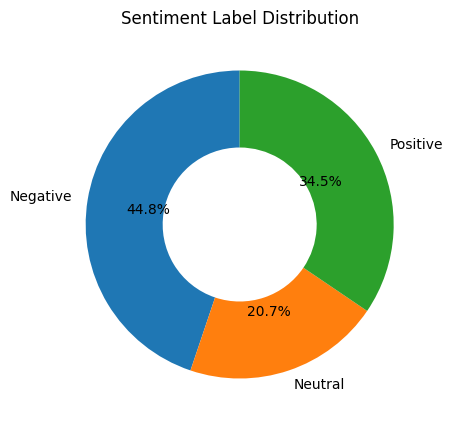

In [4]:
# Group the data by sentiment label
sentiment_grouped = reviews.groupby('sentiment_label').agg({'summary': 'count', 'num_words': 'mean', 'sentiment_score': 'mean'}).reset_index()

sentiment_grouped.head()

# Create a pie chart
fig, ax = plt.subplots(figsize=(5, 5)) 
ax.pie(sentiment_grouped['summary'], labels=sentiment_grouped['sentiment_label'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# Display the plot
ax.set_title('Sentiment Label Distribution')
plt.show()

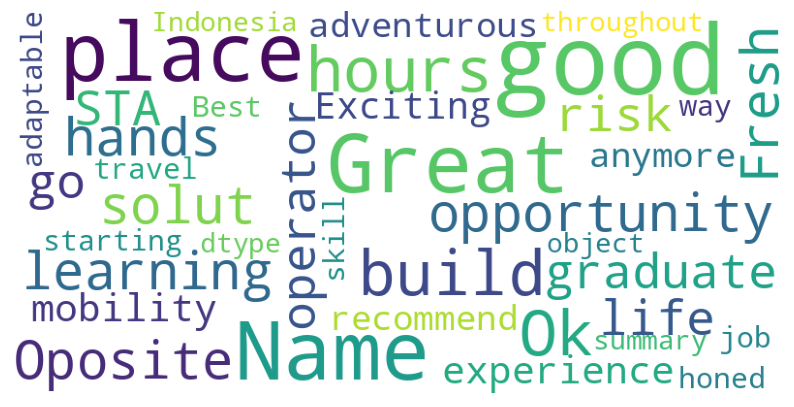

In [5]:
positive_reviews = reviews[reviews['sentiment_label'] == 'Positive']

# Sample size
reviews_sample = reviews.sample(frac = 0.1, replace = False, random_state=42)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 50,
        max_font_size = 50,
        scale = 2,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
    
# Show wordcloud
show_wordcloud(positive_reviews["summary"])


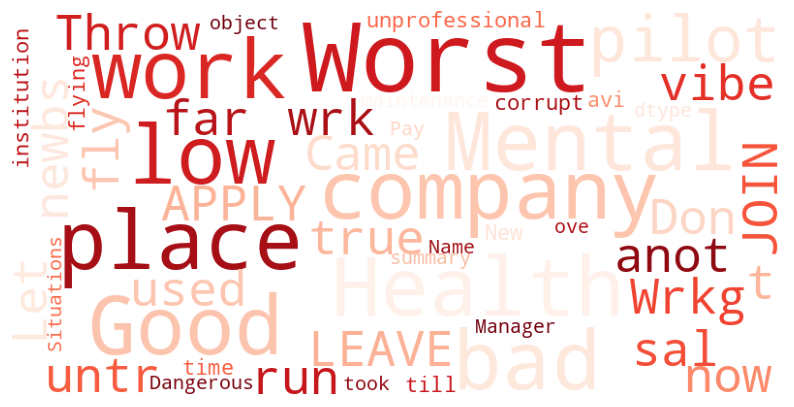

In [6]:
negative_reviews = reviews[reviews['sentiment_label'] == 'Negative']

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color = 'white',
        colormap = 'Reds',
        max_words = 50,
        max_font_size = 50,
        scale = 2,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(negative_reviews["summary"])